In [1]:
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms, utils
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import time

In [2]:
# Path to the root folder containing 15 subfolders (one per class)
base_dir = r"F:\Classification\dataset"

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32
NUM_CLASSES = 15
EPOCHS = 20
VALID_SPLIT = 0.2

In [5]:
# Data transforms ensuring size 224x224x3
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(40),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [6]:
# Full dataset
full_dataset = datasets.ImageFolder(base_dir)
class_names = full_dataset.classes

In [7]:
# Create train/validation split indices
total_size = len(full_dataset)
indices = list(range(total_size))
split = int(np.floor(VALID_SPLIT * total_size))
np.random.seed(42)
np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

In [8]:
# Subsets with transforms
dataset_train = Subset(datasets.ImageFolder(base_dir, data_transforms['train']), train_idx)
dataset_val = Subset(datasets.ImageFolder(base_dir, data_transforms['val']), val_idx)

dataloaders = {
    'train': DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val)}
class_names = dataset_train.dataset.classes

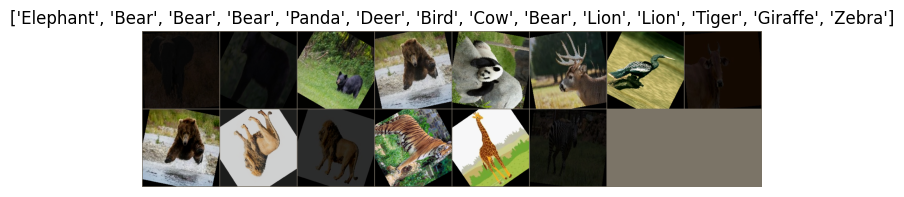

In [9]:
# Visualize a batch
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title: plt.title(title)
    plt.axis('off')

inputs, labels = next(iter(dataloaders['train']))
out = utils.make_grid(inputs[:14])
plt.figure(figsize=(8,8))
imshow(out, title=[class_names[i] for i in labels[:14]])
plt.show()

In [ ]:
# Model setup (EfficientNet B0)
model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, NUM_CLASSES)
)
model = model.to(DEVICE)

In [11]:
# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

# Training loop with tqdm and timing
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}


Epoch 1/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.66it/s, acc=0.598, loss=2.04]


train Loss: 1.9757 Acc: 0.5784 in 10.52s


val: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s, acc=0.857, loss=1.36]


val Loss: 1.3505 Acc: 0.8479 in 9.49s
Epoch 2/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.80it/s, acc=0.876, loss=1.08]


train Loss: 1.0480 Acc: 0.8464 in 10.22s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.93, loss=0.839] 


val Loss: 0.8305 Acc: 0.9201 in 9.34s
Epoch 3/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.912, loss=0.749]


train Loss: 0.7240 Acc: 0.8817 in 10.26s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.948, loss=0.628]


val Loss: 0.6211 Acc: 0.9381 in 9.33s
Epoch 4/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.934, loss=0.592]


train Loss: 0.5719 Acc: 0.9023 in 10.25s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.948, loss=0.523]


val Loss: 0.5174 Acc: 0.9381 in 9.34s
Epoch 5/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.949, loss=0.5]  


train Loss: 0.4832 Acc: 0.9177 in 10.25s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.958, loss=0.458]


val Loss: 0.4537 Acc: 0.9485 in 9.36s
Epoch 6/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.955, loss=0.441]


train Loss: 0.4265 Acc: 0.9229 in 10.25s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.948, loss=0.412]


val Loss: 0.4081 Acc: 0.9381 in 9.33s
Epoch 7/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.77it/s, acc=0.954, loss=0.415]


train Loss: 0.4014 Acc: 0.9222 in 10.27s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.958, loss=0.372]


val Loss: 0.3681 Acc: 0.9485 in 9.34s
Epoch 8/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s, acc=0.965, loss=0.369]


train Loss: 0.3571 Acc: 0.9332 in 10.24s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.958, loss=0.364]


val Loss: 0.3599 Acc: 0.9485 in 9.35s
Epoch 9/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.973, loss=0.331]


train Loss: 0.3204 Acc: 0.9402 in 10.25s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.961, loss=0.323]


val Loss: 0.3199 Acc: 0.9510 in 9.36s
Epoch 10/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s, acc=0.972, loss=0.318]


train Loss: 0.3071 Acc: 0.9396 in 10.24s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.956, loss=0.311]


val Loss: 0.3074 Acc: 0.9459 in 9.33s
Epoch 11/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s, acc=0.976, loss=0.296]


train Loss: 0.2861 Acc: 0.9434 in 10.23s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.966, loss=0.294]


val Loss: 0.2909 Acc: 0.9562 in 9.34s
Epoch 12/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s, acc=0.966, loss=0.298]


train Loss: 0.2878 Acc: 0.9338 in 10.23s


val: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s, acc=0.966, loss=0.283]


val Loss: 0.2797 Acc: 0.9562 in 9.16s
Epoch 13/20


train: 100%|██████████| 49/49 [00:09<00:00,  4.94it/s, acc=0.981, loss=0.247]


train Loss: 0.2392 Acc: 0.9486 in 9.93s


val: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s, acc=0.966, loss=0.242]


val Loss: 0.2393 Acc: 0.9562 in 9.54s
Epoch 14/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.70it/s, acc=0.984, loss=0.243]


train Loss: 0.2346 Acc: 0.9512 in 10.44s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.966, loss=0.264]


val Loss: 0.2616 Acc: 0.9562 in 9.33s
Epoch 15/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.982, loss=0.245]


train Loss: 0.2367 Acc: 0.9492 in 10.25s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.966, loss=0.25] 


val Loss: 0.2472 Acc: 0.9562 in 9.34s
Epoch 16/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.985, loss=0.235]


train Loss: 0.2269 Acc: 0.9524 in 10.25s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.974, loss=0.234]


val Loss: 0.2313 Acc: 0.9639 in 9.36s
Epoch 17/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.987, loss=0.216]


train Loss: 0.2085 Acc: 0.9544 in 10.25s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.969, loss=0.235]


val Loss: 0.2323 Acc: 0.9588 in 9.34s
Epoch 18/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s, acc=0.982, loss=0.223]


train Loss: 0.2155 Acc: 0.9492 in 10.27s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.971, loss=0.219]


val Loss: 0.2167 Acc: 0.9613 in 9.33s
Epoch 19/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.69it/s, acc=0.986, loss=0.215]


train Loss: 0.2076 Acc: 0.9531 in 10.45s


val: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s, acc=0.977, loss=0.227]


val Loss: 0.2244 Acc: 0.9665 in 9.55s
Epoch 20/20


train: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s, acc=0.98, loss=0.212] 


train Loss: 0.2052 Acc: 0.9473 in 10.23s


val: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s, acc=0.977, loss=0.23] 

val Loss: 0.2273 Acc: 0.9665 in 9.36s


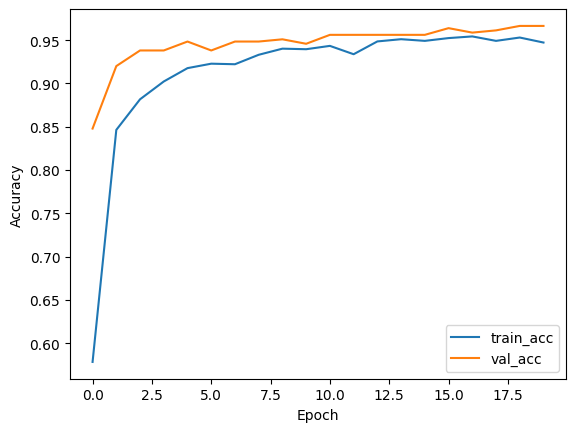

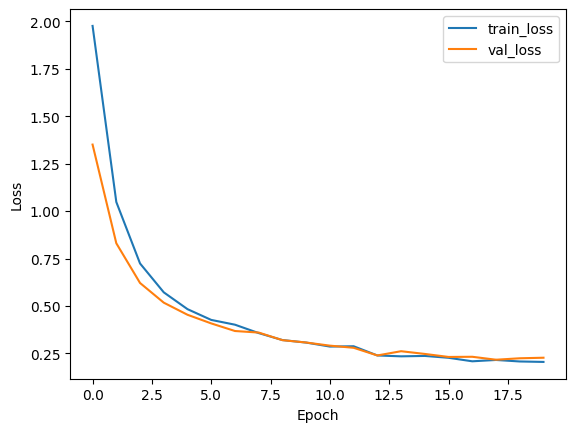

In [12]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for phase in ['train', 'val']:
        since = time.time()
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        loader = dataloaders[phase]

        # Progress bar
        loop = tqdm(loader, desc=phase)
        for inputs, labels in loop:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # update tqdm metrics
            loop.set_postfix(loss=running_loss/((loop.n+1)*BATCH_SIZE), acc=(running_corrects.double().item()/((loop.n+1)*BATCH_SIZE)))

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc.item())

        elapsed = time.time() - since
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} in {elapsed:.2f}s")

# Plot history
plt.figure(); plt.plot(history['train_acc'], label='train_acc'); plt.plot(history['val_acc'], label='val_acc'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()
plt.figure(); plt.plot(history['train_loss'], label='train_loss'); plt.plot(history['val_loss'], label='val_loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

# Fine-tune last 20 layers
for param in list(model.features.parameters())[-20:]: param.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
# Additional fine-tuning epochs here...

# Save model
torch.save(model.state_dict(), r"F:\Classification\classifi.pth")

Predicted Class: Dog (88.01% confidence)


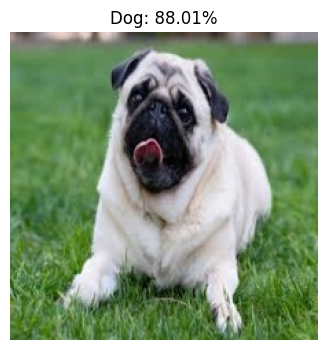

In [14]:
from PIL import Image
from torchvision import transforms, models

# ----------------------------
# USER PARAMETERS
# ----------------------------
IMAGE_PATH = "F:\Classification\dataset\Dog\Dog_5_1.jpg"   # e.g. '/data/images/tiger.jpg'
MODEL_PATH = r"F:\Classification\classifi.pth"  # e.g. 'models/best_model.pth'
CLASS_NAMES = [
    'Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin',
    'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion',
    'Panda', 'Tiger', 'Zebra'
]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_HEIGHT, IMG_WIDTH = 224, 224

# ----------------------------
# DEFINE TRANSFORMS
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----------------------------
# LOAD IMAGE
# ----------------------------
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found at {IMAGE_PATH}")

image = Image.open(IMAGE_PATH).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(DEVICE)  # add batch dim

# ----------------------------
# BUILD MODEL ARCHITECTURE
# ----------------------------
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, len(CLASS_NAMES))
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# ----------------------------
# INFERENCE
# ----------------------------
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    confidence, preds = torch.max(probs, 1)

pred_class = CLASS_NAMES[preds.item()]
pred_conf = confidence.item()

print(f"Predicted Class: {pred_class} ({pred_conf*100:.2f}% confidence)")

# ----------------------------
# OPTIONAL: DISPLAY IMAGE
# ----------------------------
plt.figure(figsize=(4,4))
plt.imshow(np.array(image))
plt.title(f"{pred_class}: {pred_conf*100:.2f}%")
plt.axis('off')
plt.show()